<a href="https://colab.research.google.com/github/logchambers/REU-Team-1/blob/main/Custom_Model_without_LRScheduler_Jorge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install preprocess
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==1.0.0-alpha0
!pip install h5py pyyaml


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████████████████████████▌| 834.1 MB 1.2 MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x3a5c6000 @  0x7f0b0f28c615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 846.0 MB 21 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 1.1 MB/s 
Looking in index

Import requiered libraries

In [ ]:
%load_ext tensorboard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import preprocess as pp
import cv2

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import  PIL.Image

Using tf.config.list_physical_devices('GPU') to confirm that TensorFlow is using the GPU.

Also limiting the GPU consumption

In [ ]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


Import the labeled dataset from  NASA’s LAADS DAAC
archives. 

Fast Fourier Transform has been applied to the images in the dataset for denoising.

In [ ]:
data_path = ('/content/drive/MyDrive/fft-denoised/')

#data_path = ('/content/drive/MyDrive/Big Data REU 2022 Team 1/REU 2022 Research/Datasets/new-test-data_Seraj/fft-denoised')
img_path= data_path

os.chdir(img_path)
print(os.path.abspath(os.getcwd()))


/content/drive/MyDrive/fft-denoised


Loading the pre-trained model Inception V3, which is trained with imagenet dataset.

All layers in the Inception V3 has been assigned to not be trainable.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf

from keras import regularizers
from keras.models import Model


base_model = InceptionV3(input_shape = (256,256,3), include_top = False, weights = 'imagenet')

# Freeze all the layers
for layer in base_model.layers:
  layer.trainable = False

# Check the trainable status of the individual layers

#for layer in base_model.layers:
  #print(layer, layer.trainable)

#base_model.summary()

87924736/87910968 [==============================] - 3s 0us/step


Split the model up to the module mixed7.

Assigned 'mixed7' as the last layer from the model, thus the rest of the layers won't be used during training or evaluation.

The reason for that is because for the Inception Model V3, the largest feature map is produced by this layer, and further layers have lower dimensions. So for the purpose of feature extraction, we want to use the feature map with the most dimensions possible.

In [ ]:
last_layer = base_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 14, 14, 768)


Applied regularizers to all Conv2D layers

In [ ]:

for layer in base_model.layers:
  if layer.__class__.__name__ == 'Conv2D':
    layer.kernel_regularizer = keras.regularizers.l1(0.0001)
    layer.kernel_regularizer = keras.regularizers.l2(0.0001)

    #tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)  # L1 + L2 penalties

Defining the custom trainable layers.

In [ ]:
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.layers import Conv2D, Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model



def model_call():


  x = layers.Flatten()(last_output) #mixed 7

  # Add a fully connected layer with 1,024 hidden units and ReLU activation

  x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.3)(x)      

  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)         

  model = Model(base_model.input, x)

  
        
  model.compile(optimizer = Adam(lr=1e-04),
  #model.compile(optimizer = Adam(lr=1e-06),
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])
  


  return model


In [ ]:
#model.summary()

This callback function will simply prompt, during training, your validation accuracy % 

if validation accuracy achieves over 90%, 93% it will be notified during training.
if validation accuracy is higher than 94%, it will stop training.

For training, if you achieve 100% or 95% training accuracy, it will be notified during training.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

    elif(logs.get('val_accuracy')>0.9499):
      print("\nReached 95% or more validation accuracy, training finished.")
      self.model.stop_training = True

    elif(logs.get('val_accuracy')>0.93):
      print(f"\nReached 93% validation accuracy mark!!!")
      
    elif(logs.get('val_accuracy')>0.8999):
      print(f"\nReached 90% validation accuracy mark!")

    #elif(logs.get('accuracy')>0.9499):
     # print(f"\nReached 95%  accuracy!")
      
      
      
accstop = myCallback()

Defined the data generators for the train class, test class and validation class respectively.

Also applied Data Augmentation.

Class mode is set to binary since we are interested only in two types of output, true or false.


In [ ]:

batch_size = 35 #Defined batch size


train_datagen = ImageDataGenerator(
        width_shift_range = 0.2,
        rescale=1/255,
        shear_range=0.2,
        horizontal_flip=True,
        )


test_datagen = ImageDataGenerator(
        rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(256, 256),
        batch_size= batch_size,
        #shuffle = True,
        class_mode='binary')



train_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
  train = train_generator.next()
  train_list.append(train[0])
  batch_index = batch_index + 1

train_array = np.asarray(train_list)


validation_generator = train_datagen.flow_from_directory(
        './validation',
        target_size=(256, 256),
        batch_size= 35,
        class_mode='binary')


validation_list = []
batch_index = 0
while batch_index <= validation_generator.batch_index:
  validation = validation_generator.next()
  validation_list.append(validation[0])
  batch_index = batch_index + 1

validation_array = np.asarray(validation_list)


test_generator = test_datagen.flow_from_directory(
        './test',
        target_size=(256, 256),
        batch_size= batch_size,
        class_mode= 'binary')



test_list = []
batch_index = 0
while batch_index <= test_generator.batch_index:
  test = test_generator.next()
  test_list.append(test[0])
  batch_index = batch_index + 1 

test_array = np.asarray(test_list)



Found 710 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Found 140 images belonging to 2 classes.
Found 236 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
model1 = model_call()

plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True) 

 

In [ ]:
from tensorflow.keras import callbacks

test_acc_per_fold = []; test_loss_per_fold = []

model = model_call()
epoch = 300


kh = model.fit(        
        train_generator,
        steps_per_epoch= 3,
        #steps_per_epoch= 120 // batch_size,
        epochs = epoch,
        validation_data=validation_generator,
        callbacks = [accstop],
        validation_steps= 1
        #validation_steps= 32 // batch_size
        )
   
scores = model.evaluate(train_generator, verbose=0)

results = model.evaluate(validation_generator, verbose = 0)

test_results = model.evaluate(test_generator, verbose = 0)

best_acc = max(kh.history['accuracy']); best_loss = min(kh.history['loss']); best_val_acc = max(kh.history['val_accuracy']); best_val_loss = min(kh.history['val_loss'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/300
3/3 [==============================] - 11s 3s/step - loss: 1.8031 - accuracy: 0.5048 - val_loss: 1.8663 - val_accuracy: 0.4000
Epoch 2/300
3/3 [==============================] - 6s 2s/step - loss: 1.0786 - accuracy: 0.5810 - val_loss: 0.8162 - val_accuracy: 0.5143
Epoch 3/300
3/3 [==============================] - 6s 3s/step - loss: 0.6243 - accuracy: 0.6476 - val_loss: 0.4803 - val_accuracy: 0.7714
Epoch 4/300
3/3 [==============================] - 5s 2s/step - loss: 0.6190 - accuracy: 0.6750 - val_loss: 0.4759 - val_accuracy: 0.8286
Epoch 5/300
3/3 [==============================] - 6s 3s/step - loss: 0.5037 - accuracy: 0.7333 - val_loss: 0.7076 - val_accuracy: 0.6286
Epoch 6/300
3/3 [==============================] - 6s 3s/step - loss: 0.6270 - accuracy: 0.6571 - val_loss: 0.5360 - val_accuracy: 0.7429
Epoch 7/300
3/3 [==============================] - 6s 3s/step - loss: 0.5059 - accuracy: 0.7524 - val_loss: 0.7232 - val_accuracy: 0.5143
Epoch 8/300
3/3 [================

In [ ]:

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------')

print(f'Training Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%;  \n' )

print(f'Validation Score: {model.metrics_names[0]} of {results[0]}; validation {model.metrics_names[1]} of {results[1]*100}%;  \n' )

print(f'Test Score: test {model.metrics_names[0]} of {test_results[0]}; test {model.metrics_names[1]} of {test_results[1]*100}%;  \n' )

print(f' Best Accuracy: {best_acc*100}%;  Best Loss: {best_loss}; Best Val_Accuracy: {best_val_acc*100}%; Best Val_Loss: {best_val_loss} \n' )


print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Training Score : loss of 0.1774672567844391; accuracy of 93.80281567573547%;  

Validation Score: loss of 0.6163803935050964; validation accuracy of 72.14285731315613%;  

Test Score: test loss of 0.6864001154899597; test accuracy of 75.42372941970825%;  

 Best Accuracy: 99.04761910438538%;  Best Loss: 0.09554336220026016; Best Val_Accuracy: 88.57142925262451%; Best Val_Loss: 0.2825929820537567 

-----------------------------------------------------------------------------------------------------------------------------------------------------------------


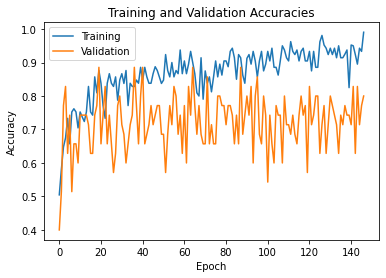

In [ ]:

plt.plot(kh.history['accuracy'])
plt.plot(kh.history['val_accuracy'])
plt.title('Training and Validation Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper left')
plt.show()

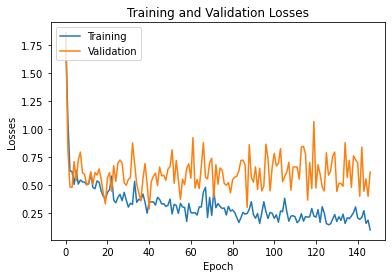

In [ ]:

plt.plot(kh.history['loss'])
plt.plot(kh.history['val_loss'])
plt.title('Training and Validation Losses')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper left')
plt.show()

In [ ]:
_, acc = model.evaluate(test_generator)
print(acc)


7/7 [==============================] - 5s 646ms/step - loss: 0.6864 - accuracy: 0.7542
0.7542372941970825


In [ ]:
_, acc = model.evaluate(validation_generator)
print(acc)

4/4 [==============================] - 6s 2s/step - loss: 0.6247 - accuracy: 0.7429
0.7428571581840515


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in validation:
  X,y = validation
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

f1_score = (2 * pre.result().numpy() * re.result())/(pre.result().numpy() + re.result())

print('For Validation: ')
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F1 Score: {f1_score}')



For Validation: 
Precision: 0.8125, Recall: 0.6842105388641357, Accuracy: 0.7428571581840515, F1 Score: 0.7428571581840515


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test:
  X,y = test
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

f1_score = (2 * pre.result().numpy() * re.result())/(pre.result().numpy() + re.result())

print('For Validation: ')
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F1 Score: {f1_score}')


For Validation: 
Precision: 1.0, Recall: 0.8461538553237915, Accuracy: 0.9230769276618958, F1 Score: 0.9166666865348816


In [ ]:
pred = model.predict(validation_generator)
test_pred = model.predict(test_generator)

#pred = model.predict( test_generator )

print("validation predictions:\n")

def countpredictions(predictions, gw = 0, ngw = 0):
  for pred in predictions:
    if pred > 0.5:
      ngw += 1
    else:
      gw += 1
  return gw, ngw

print(countpredictions(pred, 0, 0))

print("\ntest predictions:\n")

def countpredictions(predictions, gw = 0, ngw = 0):
  for test_pred in predictions:
    if test_pred > 0.5:
      ngw += 1
    else:
      gw += 1
  return gw, ngw

print(countpredictions(test_pred, 0, 0))


validation predictions:

(79, 61)

test predictions:

(135, 101)


In [ ]:
import sklearn.metrics as metrics



print("Confusion Matrix: \n")
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
pred = np.round(pred)
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=pred)
confusion_matrix

#true positives, false negatives
#false positives, tru negatives

Confusion Matrix: 



array([[41, 29],
       [38, 32]])